In [14]:
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw

In [15]:
art_path = "./data/art-style-smushing/Portraits/Portraits/"
humans_path = "./data/art-style-smushing/Humans/"

def load_images(path, count):
    with os.scandir(path) as files:
        images = []
        for file in files:
            # print(f"parsing file: {file.name}")
            if file.name.endswith((".jpg", ".png")):
                img = Image.open(file)
                images.append(img)
            if len(images) >= count:
                break
        return images

# art_images = load_images(art_path,1000)
# human_images = load_images(humans_path, 1000)

# class ImageDataset(Dataset):
#     def __init__(self, images, transform=None):
#         self.images = images
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         if self.transform:
#             image = self.transform(image)
#         return image

def load_image_paths(path, count):
    with os.scandir(path) as files:
        image_paths = []
        for file in files:
            if file.name.endswith((".jpg", ".png")):
                image_paths.append(os.path.join(path, file.name))
            if len(image_paths) >= count:
                break
        return image_paths

art_image_paths = load_image_paths(art_path, 10000)
human_image_paths = load_image_paths(humans_path, 10000)

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])


art_dataset = ImageDataset(art_image_paths, transform=transform)
art_loader = DataLoader(art_dataset, batch_size=32, shuffle=True, num_workers=16)

humans_dataset = ImageDataset(human_image_paths, transform=transform)
art_loader = DataLoader(humans_dataset,batch_size=32, shuffle=True, num_workers=16)

In [16]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.LazyConv2d(32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.LazyConv2d(64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.LazyConv2d(128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.fc = nn.Linear(32 * 32 * 128, 512)
        self.mu_fc = nn.Linear(512, 32)
        self.logvar_fc = nn.Linear(512, 32)

        # Decoder
        self.fc2 = nn.Linear(32, 512)
        self.fc3 = nn.LazyLinear(32 * 32 * 128)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 3, 2, 1, output_padding=1)

    def encoder(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 32 * 32 * 128)
        x = F.relu(self.fc(x))
        # print(f"encoder before mu logvar {x}")
        mu = self.mu_fc(x)
        logvar = self.logvar_fc(x)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, x):
        x = torch.tanh(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = x.view(-1, 128, 32, 32)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        x = torch.sigmoid(x)
        return x
    
    def forward(self, x):
        # print(f"forward with x {x}")
        mu, logvar = self.encoder(x)
        # print(f"mu {mu} \n logvar {logvar}")
        z = self.sampling(mu, logvar)
        # print(f"z {z}")
        x_hat = self.decoder(z)
        # print(f"x_hat {x_hat}")
        return x_hat, mu, logvar

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

# # loss_fn = nn.MSELoss()
# def vae_loss(x_hat, x, mu, logvar):
#     mse = nn.functional.mse_loss(x_hat, x, reduction='sum')
#     kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return mse + kld


def loss_function(y, x, mu, std):
    x = (x + 1) / 2  # Rescale x to be in the range [0, 1]
    x = torch.clamp(x, 0, 1)
    ERR = F.binary_cross_entropy(y.view(-1, 3*256*256), x.view(-1, 3*256*256), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, ERR, KLD

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)


epochs=20
for epoch in range(epochs):
    train_loss=0
    for data in art_loader:
        model.train()
        data = data.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(data)
        # print(x_hat)
        loss, error, kld = loss_function(x_hat, data, mu, logvar)
        # print(loss)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")
    scheduler.step(train_loss/len(art_loader))
        

/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [1/20], Loss: 2103318.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/20], Loss: 2182690.0


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [3/20], Loss: 2064754.5


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [4/20], Loss: 2128974.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/20], Loss: 2115361.75


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [6/20], Loss: 2194912.5


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [7/20], Loss: 2149254.75


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/20], Loss: 2191456.0


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/20], Loss: 2213628.75


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [10/20], Loss: 2184315.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/20], Loss: 2197645.0


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/20], Loss: 2181212.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [13/20], Loss: 2156731.75


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/20], Loss: 2310009.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [15/20], Loss: 2198408.0


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16/20], Loss: 2190677.75


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed i

Epoch [17/20], Loss: 2080192.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [18/20], Loss: 2084115.25


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [19/20], Loss: 2170089.0


/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [20/20], Loss: 2187682.25


tensor([[[[0.6539, 0.6550, 0.6539,  ..., 0.6550, 0.6539, 0.7270],
          [0.6550, 0.6608, 0.6550,  ..., 0.6608, 0.6550, 0.7160],
          [0.6539, 0.6550, 0.6539,  ..., 0.6550, 0.6539, 0.7270],
          ...,
          [0.6550, 0.6608, 0.6550,  ..., 0.6608, 0.6550, 0.7160],
          [0.6539, 0.6550, 0.6539,  ..., 0.6550, 0.6539, 0.7270],
          [0.7315, 0.7231, 0.7315,  ..., 0.7231, 0.7315, 0.7632]],

         [[0.6370, 0.6364, 0.6370,  ..., 0.6364, 0.6370, 0.7003],
          [0.6363, 0.6348, 0.6363,  ..., 0.6348, 0.6363, 0.6889],
          [0.6370, 0.6364, 0.6370,  ..., 0.6364, 0.6370, 0.7003],
          ...,
          [0.6363, 0.6348, 0.6363,  ..., 0.6348, 0.6363, 0.6889],
          [0.6370, 0.6364, 0.6370,  ..., 0.6364, 0.6370, 0.7003],
          [0.7027, 0.6903, 0.7027,  ..., 0.6903, 0.7027, 0.7308]],

         [[0.6252, 0.6241, 0.6252,  ..., 0.6241, 0.6252, 0.6846],
          [0.6238, 0.6225, 0.6238,  ..., 0.6225, 0.6238, 0.6748],
          [0.6252, 0.6241, 0.6252,  ..., 0

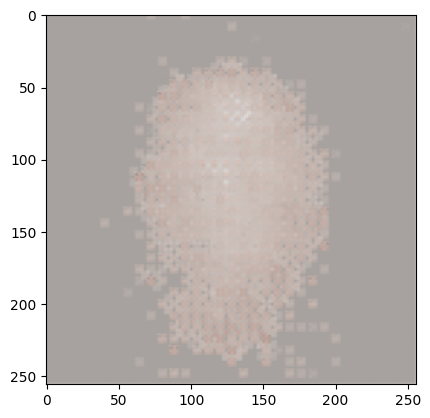

tensor([[[[0.8558, 0.8565, 0.8225,  ..., 0.8549, 0.8225, 0.8225],
          [0.8555, 0.8518, 0.8225,  ..., 0.8656, 0.8588, 0.8468],
          [0.8225, 0.8225, 0.8225,  ..., 0.8586, 0.8582, 0.8582],
          ...,
          [0.7992, 0.7929, 0.7983,  ..., 0.7943, 0.7957, 0.8045],
          [0.7950, 0.7887, 0.8043,  ..., 0.7791, 0.8036, 0.8119],
          [0.8036, 0.8011, 0.8099,  ..., 0.7944, 0.8130, 0.8157]],

         [[0.8642, 0.8644, 0.7892,  ..., 0.8612, 0.7892, 0.7892],
          [0.8643, 0.8553, 0.7892,  ..., 0.8718, 0.8681, 0.8353],
          [0.7892, 0.7892, 0.7892,  ..., 0.8678, 0.8679, 0.8674],
          ...,
          [0.7740, 0.7736, 0.7729,  ..., 0.7664, 0.7706, 0.7756],
          [0.7639, 0.7693, 0.7724,  ..., 0.7570, 0.7761, 0.7850],
          [0.7753, 0.7751, 0.7799,  ..., 0.7643, 0.7851, 0.7852]],

         [[0.8600, 0.8594, 0.7714,  ..., 0.8558, 0.7714, 0.7714],
          [0.8600, 0.8491, 0.7714,  ..., 0.8670, 0.8639, 0.8253],
          [0.7714, 0.7714, 0.7714,  ..., 0

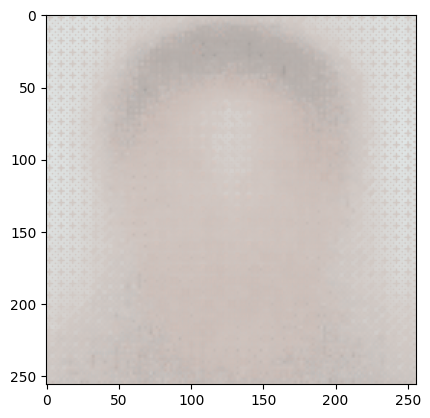

tensor([[[[0.6539, 0.6550, 0.6539,  ..., 0.6550, 0.6539, 0.7270],
          [0.6550, 0.6608, 0.6550,  ..., 0.6608, 0.6550, 0.7160],
          [0.6539, 0.6550, 0.6539,  ..., 0.6550, 0.6539, 0.7270],
          ...,
          [0.6550, 0.6608, 0.6550,  ..., 0.6608, 0.6550, 0.7160],
          [0.6539, 0.6550, 0.6539,  ..., 0.6550, 0.6539, 0.7270],
          [0.7315, 0.7231, 0.7315,  ..., 0.7231, 0.7315, 0.7632]],

         [[0.6370, 0.6364, 0.6370,  ..., 0.6364, 0.6370, 0.7003],
          [0.6363, 0.6348, 0.6363,  ..., 0.6348, 0.6363, 0.6889],
          [0.6370, 0.6364, 0.6370,  ..., 0.6364, 0.6370, 0.7003],
          ...,
          [0.6363, 0.6348, 0.6363,  ..., 0.6348, 0.6363, 0.6889],
          [0.6370, 0.6364, 0.6370,  ..., 0.6364, 0.6370, 0.7003],
          [0.7027, 0.6903, 0.7027,  ..., 0.6903, 0.7027, 0.7308]],

         [[0.6252, 0.6241, 0.6252,  ..., 0.6241, 0.6252, 0.6846],
          [0.6238, 0.6225, 0.6238,  ..., 0.6225, 0.6238, 0.6748],
          [0.6252, 0.6241, 0.6252,  ..., 0

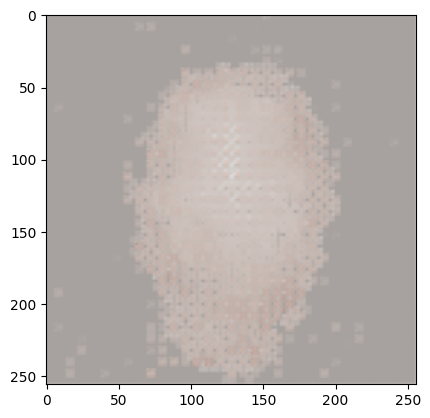

tensor([[[[0.8550, 0.8557, 0.8225,  ..., 0.8568, 0.8225, 0.8225],
          [0.8548, 0.8511, 0.8225,  ..., 0.8683, 0.8615, 0.8487],
          [0.8225, 0.8225, 0.8225,  ..., 0.8613, 0.8609, 0.8609],
          ...,
          [0.7972, 0.7895, 0.7949,  ..., 0.7953, 0.7966, 0.8050],
          [0.7910, 0.7841, 0.8023,  ..., 0.7807, 0.8046, 0.8125],
          [0.8009, 0.7983, 0.8086,  ..., 0.7954, 0.8136, 0.8161]],

         [[0.8627, 0.8629, 0.7892,  ..., 0.8650, 0.7892, 0.7892],
          [0.8629, 0.8540, 0.7892,  ..., 0.8763, 0.8734, 0.8388],
          [0.7892, 0.7892, 0.7892,  ..., 0.8731, 0.8732, 0.8727],
          ...,
          [0.7729, 0.7720, 0.7706,  ..., 0.7672, 0.7714, 0.7761],
          [0.7603, 0.7668, 0.7706,  ..., 0.7585, 0.7770, 0.7856],
          [0.7734, 0.7733, 0.7789,  ..., 0.7652, 0.7857, 0.7856]],

         [[0.8583, 0.8577, 0.7714,  ..., 0.8602, 0.7714, 0.7714],
          [0.8583, 0.8476, 0.7714,  ..., 0.8722, 0.8700, 0.8293],
          [0.7714, 0.7714, 0.7714,  ..., 0

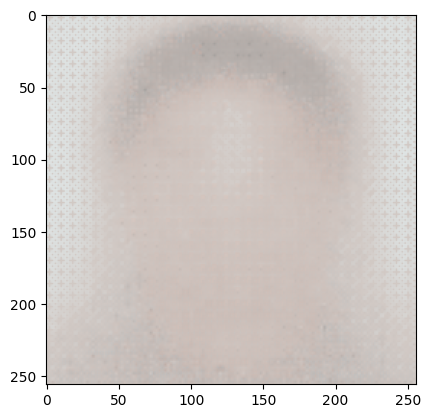

tensor([[[[0.8610, 0.8618, 0.8225,  ..., 0.8619, 0.8225, 0.8225],
          [0.8607, 0.8565, 0.8225,  ..., 0.8746, 0.8667, 0.8524],
          [0.8225, 0.8225, 0.8225,  ..., 0.8666, 0.8661, 0.8661],
          ...,
          [0.7979, 0.7906, 0.7958,  ..., 0.8061, 0.8199, 0.8204],
          [0.7921, 0.7851, 0.8024,  ..., 0.7972, 0.8221, 0.8235],
          [0.8016, 0.7989, 0.8086,  ..., 0.8049, 0.8240, 0.8230]],

         [[0.8748, 0.8750, 0.7892,  ..., 0.8751, 0.7892, 0.7892],
          [0.8749, 0.8649, 0.7892,  ..., 0.8871, 0.8833, 0.8455],
          [0.7892, 0.7892, 0.7892,  ..., 0.8830, 0.8831, 0.8826],
          ...,
          [0.7734, 0.7726, 0.7712,  ..., 0.7786, 0.7958, 0.7920],
          [0.7614, 0.7674, 0.7707,  ..., 0.7765, 0.7962, 0.7986],
          [0.7739, 0.7737, 0.7790,  ..., 0.7754, 0.7985, 0.7939]],

         [[0.8722, 0.8716, 0.7714,  ..., 0.8717, 0.7714, 0.7714],
          [0.8723, 0.8603, 0.7714,  ..., 0.8843, 0.8813, 0.8370],
          [0.7714, 0.7714, 0.7714,  ..., 0

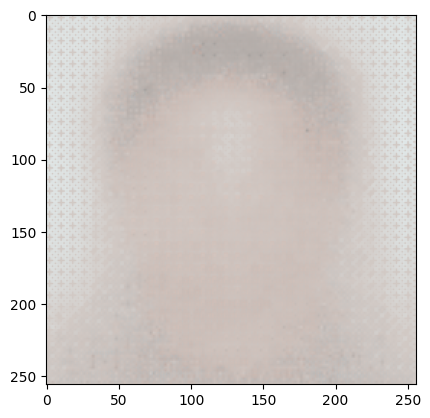

tensor([[[[0.8563, 0.8571, 0.8225,  ..., 0.8602, 0.8225, 0.8225],
          [0.8561, 0.8523, 0.8225,  ..., 0.8722, 0.8643, 0.8506],
          [0.8225, 0.8225, 0.8225,  ..., 0.8641, 0.8637, 0.8636],
          ...,
          [0.7989, 0.7936, 0.7999,  ..., 0.8009, 0.8097, 0.8135],
          [0.7903, 0.7870, 0.8054,  ..., 0.7914, 0.8187, 0.8215],
          [0.8012, 0.8001, 0.8107,  ..., 0.8017, 0.8221, 0.8217]],

         [[0.8654, 0.8655, 0.7892,  ..., 0.8717, 0.7892, 0.7892],
          [0.8655, 0.8563, 0.7892,  ..., 0.8831, 0.8787, 0.8423],
          [0.7892, 0.7892, 0.7892,  ..., 0.8783, 0.8784, 0.8779],
          ...,
          [0.7733, 0.7734, 0.7739,  ..., 0.7720, 0.7850, 0.7848],
          [0.7596, 0.7670, 0.7734,  ..., 0.7693, 0.7920, 0.7957],
          [0.7727, 0.7737, 0.7805,  ..., 0.7710, 0.7957, 0.7920]],

         [[0.8613, 0.8607, 0.7714,  ..., 0.8678, 0.7714, 0.7714],
          [0.8614, 0.8504, 0.7714,  ..., 0.8799, 0.8760, 0.8334],
          [0.7714, 0.7714, 0.7714,  ..., 0

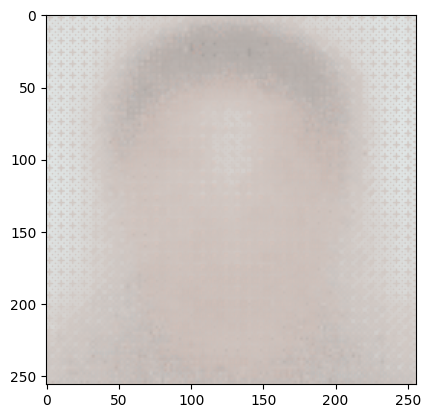

/home/software/Documents/.rianstuff/cosmos/env/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [18]:
#testing
model.eval()
with torch.no_grad():
    for count, data in enumerate(art_loader):
        data = data.to(device)
        x_hat, mu, logvar = model(data)
        print(x_hat)
        plt.imshow(x_hat[0].cpu().permute(1, 2, 0))
        plt.show()
        if(count>=5):
            break